# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2020-02-18 06:48:45,615 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2020-02-18 06:48:45,637 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnMVpBRS8xWkFFRlNMQ19RT1N0ZXN0XzIwMDIwNF8yMDAyMDRfMTAxMzU0X21lc3NhZ2UnLCBsYXlvdXTigKY=


## Run cells

Please select over systrace files and press the run button to execute below cells.

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select some systraces to analysis.

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing 1AZEFSI6_POS_191010_191010_192902_contact.html - 178878 lines are Ok
Parsing 1AZEFSI6_POS_191010_191010_231835_contact.html - 204101 lines are Ok
Parsing 1AZEFSI6_POS_191010_191011_030806_contact.html - 186027 lines are Ok
Parsing 1ZAEFSKA_QOS_191128_191128_143137_contact.html - 161509 lines are Ok
Parsing 1ZAEFSKA_QOS_191128_191128_152843_contact.html - 169797 lines are Ok
Parsing 1ZAEFSKA_QOS_191128_191128_133429_contact.html - 167924 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters.

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

TEST_HH_systrace_BSP


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
2209.0,3.285,10.043,9.038,NaN,NaN,NaN,NaN,NaN
2855.0,NaN,NaN,NaN,NaN,NaN,NaN,0.576,NaN
1359.0,NaN,3.115,8.078,NaN,NaN,NaN,NaN,NaN
1938.0,NaN,15.389,8.791,NaN,NaN,NaN,NaN,NaN
4670.0,NaN,NaN,NaN,40.749,NaN,23.642,NaN,NaN
1238.0,0.049,1.575,2.943,NaN,NaN,NaN,NaN,1079.028
4154.0,596104.054,138.223,83.780,NaN,787.592,NaN,243.108,NaN
2270.0,2.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

TEST_HH_systrace_SEP


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
10981.0,NaN,NaN,NaN,24.361,NaN,10.753,NaN,NaN
1478.0,NaN,2.398,37.382,NaN,NaN,NaN,NaN,1656.415
2759.0,NaN,21.698,13.554,NaN,NaN,NaN,NaN,NaN
1550.0,NaN,1.470,1.117,NaN,NaN,NaN,NaN,NaN
2002.0,NaN,5.863,26.944,NaN,NaN,NaN,NaN,NaN
5173.0,68.804,796.262,87.829,NaN,504.458,NaN,182.492,NaN
2551.0,2.083,9.193,17.065,NaN,NaN,NaN,NaN,NaN
2617.0,0.773,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
sum_df1 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1) * 1000
    sum_df1.loc['mean'] = sum_df1.mean()
except:
    print("No launching time")
    
list_of_df = group2.get_marking_time()
sum_df2 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1) * 1000
    sum_df2.loc['mean'] = sum_df2.mean()
except:
    print("No launching time")

In [18]:
display(pd.concat([sum_df1, sum_df2], keys=[group1.title, group2.title], sort=False))

setSurface  Choreographer #0  Choreographer #1  \
                     pid                                                      
TEST_HH_systrace_BSP 1238.0       0.049             1.575             2.943   
                     mean         0.049             1.575             2.943   
TEST_HH_systrace_SEP 1478.0         NaN             2.398            37.382   
                     mean           NaN             2.398            37.382   

                             launching  
                     pid                
TEST_HH_systrace_BSP 1238.0   1079.028  
                     mean     1079.028  
TEST_HH_systrace_SEP 1478.0   1656.415  
                     mean     1656.415

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [19]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

setSurface  \
1AZEF_1AZEFSI6_POS_191010_191010_192902_contact time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   
1ZAEF_1ZAEFSKA_QOS_191128_191128_143137_contact time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                            time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                           Choreographer #0  \
1AZEF_1AZEFSI6_POS_191010_191010_192902_contact time                                128.265   
                                                RUNNING                             104.773   
                                                RUNNABLE                              0.685   
                                                SLEEPING                             20.218   
                                                UNINTERUPTIBLE_SLEEP                  0.129   
                                                UNINTERUPTIBLE_SLEEP(I/O)             2.459   
1ZAEF_1ZAEFSKA_QOS_191128_191128_143137_contact time                                125.199   
                                                RUNNING                              89.921   
                                                RUNNABLE                              3.547   
                                                SLEEPING                             15.505   
                                                UNINTERUPTIBLE_SLEEP                  0.016   
                                                UNINTERUPTIBLE_SLEEP(I/O)            16.209   
DIFF                                            time                                  3.066   
                                                RUNNING                              14.852   
                                                RUNNABLE                             -2.862   
                                                SLEEPING                              4.713   
                                                UNINTERUPTIBLE_SLEEP                  0.113   
                                                UNINTERUPTIBLE_SLEEP(I/O)           -13.750   

                                                                           Choreographer #1  \
1AZEF_1AZEFSI6_POS_191010_191010_192902_contact time                                 65.318   
                                                RUNNING                              21.565   
                                                RUNNABLE                              0.104   
                                                SLEEPING                             43.136   
                                                UNINTERUPTIBLE_SLEEP                  0.010   
       

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
1AZEF_1AZEFSI6_POS_191010_191010_192902_contact,time,0,128.265,65.318,0,348.736,0,34.183,0
1ZAEF_1ZAEFSKA_QOS_191128_191128_143137_contact,time,0,125.199,53.682,0,418.788,0,29.302,0
DIFF,time,0,3.066,11.636,0,-70.052,0,4.881,0


In [20]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  Choreographer #0  \
TEST_HH_systrace_BSP time                       596104.054           138.223   
                     RUNNING                        44.519            49.468   
                     RUNNABLE                        2.410             4.322   
                     SLEEPING                       53.435            83.340   
                     UNINTERUPTIBLE_SLEEP            0.657             0.452   
                     UNINTERUPTIBLE_SLEEP(I/O)       0.000             0.641   
TEST_HH_systrace_SEP time                           68.804           796.262   
                     RUNNING                        58.959           537.129   
                     RUNNABLE                        1.386            36.534   
                     SLEEPING                        0.110           131.076   
                     UNINTERUPTIBLE_SLEEP            0.559             1.102   
                     UNINTERUPTIBLE_SLEEP(I/O)       7.790            90.421   
DIFF                 time                       596035.250          -658.039   
                     RUNNING                       -14.440          -487.661   
                     RUNNABLE                        1.024           -32.212   
                     SLEEPING                       53.325           -47.736   
                     UNINTERUPTIBLE_SLEEP            0.098            -0.650   
                     UNINTERUPTIBLE_SLEEP(I/O)      -7.790           -89.780   

                                                Choreographer #1  \
TEST_HH_systrace_BSP time                                 83.780   
                     RUNNING                              34.453   
                     RUNNABLE                              3.115   
                     SLEEPING                             45.628   
                     UNINTERUPTIBLE_SLEEP                  0.584   
                     UNINTERUPTIBLE_SLEEP(I/O)             0.000   
TEST_HH_systrace_SEP time                                 87.829   
                     RUNNING                              67.888   
                     RUNNABLE                              1.349   
                     SLEEPING                              2.011   
                     UNINTERUPTIBLE_SLEEP                  0.015   
                     UNINTERUPTIBLE_SLEEP(I/O)            16.566   
DIFF                 time                                 -4.049   
                     RUNNING                             -33.435   
                     RUNNABLE                              1.766   
                     SLEEPING                             43.617   
                     UNINTERUPTIBLE_SLEEP                  0.569   
                     UNINTERUPTIBLE_SLEEP(I/O)           -16.566   

                                                bindApplication  \
TEST_HH_systrace_BSP time                                     0   
                     RUNNING                                  0   
                     RUNNABLE                                 0   
                     SLEEPING                                 0   
                     UNINTERUPTIBLE_SLEEP                     0   
                     UNINTERUPTIBLE_SLEEP(I/O)                0   
TEST_HH_systrace_SEP time                                     0   
                     RUNNING                                  0   
                     RUNNABLE                                 0   
                     SLEEPING                                 0   
                     UNINTERUPTIBLE_SLEEP                     0   
                     UNINTERUPTIBLE_SLEEP(I/O)                0   
DIFF                 time                                     0   
                     RUNNING                                  0   
                     RUNNABLE                                 0   
                     SLEEPING                                 0   
                     UNINTERUPTIBLE_SLEEP                     0   
                     UNINTER

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
TEST_HH_systrace_BSP,time,596104.054,138.223,83.780,0,787.592,0,243.108,0
TEST_HH_systrace_SEP,time,68.804,796.262,87.829,0,504.458,0,182.492,0
DIFF,time,596035.250,-658.039,-4.049,0,283.134,0,60.616,0


### Processing time of setSurface

In [19]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [22]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,avg
TEST_HH_systrace_BSP,596104.054,596104.054
TEST_HH_systrace_SEP,68.804,68.804


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [21]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

TEST_HH_systrace_BSP


,setSurface,Choreographer #0,Choreographer #1,activityStart,activityResume
uninter_reason//SyS_munmap+0x30/0x6c,0,0,0,0,0
uninter_reason//SyS_munmap+0x3c/0x78,0,0,0,4,0
uninter_reason//SyS_prctl+0x368/0x910,0,0,0,1,7
uninter_reason//__fdget_pos+0x50/0x60,6,2,5,20,28
uninter_reason//__wait_rcu_gp+0xf4/0x120,0,0,0,0,0
uninter_reason//binder_alloc_free_buf+0x24/0x44,2,1,1,1,0
uninter_reason//binder_alloc_new_buf+0x40/0x5dc,0,0,0,2,0
uninter_reason//binder_alloc_prepare_to_free+0x24/0xa4,0,0,0,1,1
uninter_reason//do_mprotect_pkey+0x98/0x22c,0,0,0,0,0
uninter_reason//do_mprotect_pkey+0xa8/0x22c,0,0,1,4,4


TEST_HH_systrace_SEP


,setSurface,Choreographer #0,Choreographer #1,activityStart,activityResume
uninter_reason//SyS_munmap+0x30/0x6c,0,4,0,0,0
uninter_reason//SyS_munmap+0x3c/0x78,0,0,0,0,0
uninter_reason//SyS_prctl+0x368/0x910,0,0,0,0,0
uninter_reason//__fdget_pos+0x50/0x60,0,0,0,0,0
uninter_reason//__wait_rcu_gp+0xf4/0x120,0,0,0,0,1
uninter_reason//binder_alloc_free_buf+0x24/0x44,0,0,0,0,0
uninter_reason//binder_alloc_new_buf+0x40/0x5dc,0,0,0,0,0
uninter_reason//binder_alloc_prepare_to_free+0x24/0xa4,0,0,0,0,0
uninter_reason//do_mprotect_pkey+0x98/0x22c,0,1,0,1,0
uninter_reason//do_mprotect_pkey+0xa8/0x22c,0,0,0,0,0


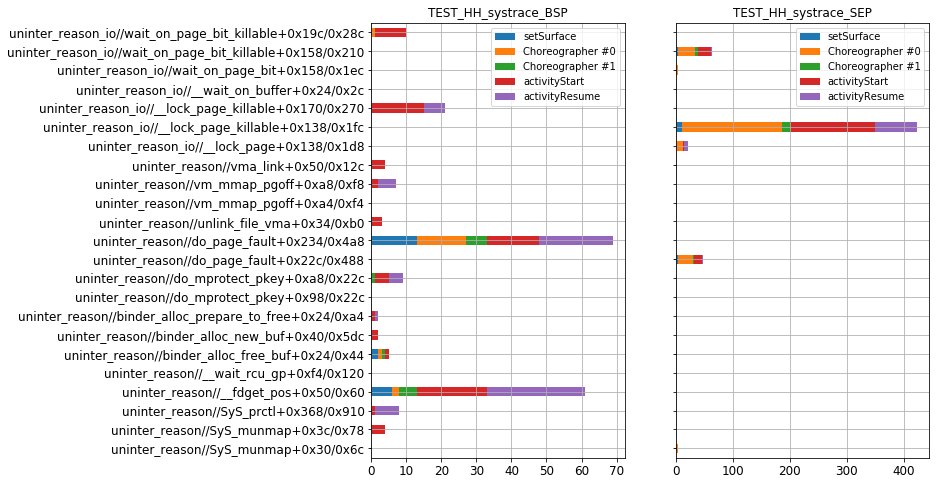

In [24]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)

print(group1.title)
display(df1)
print(group2.title)
display(df2)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

The number of count in each reason of uninterruptible sleep.

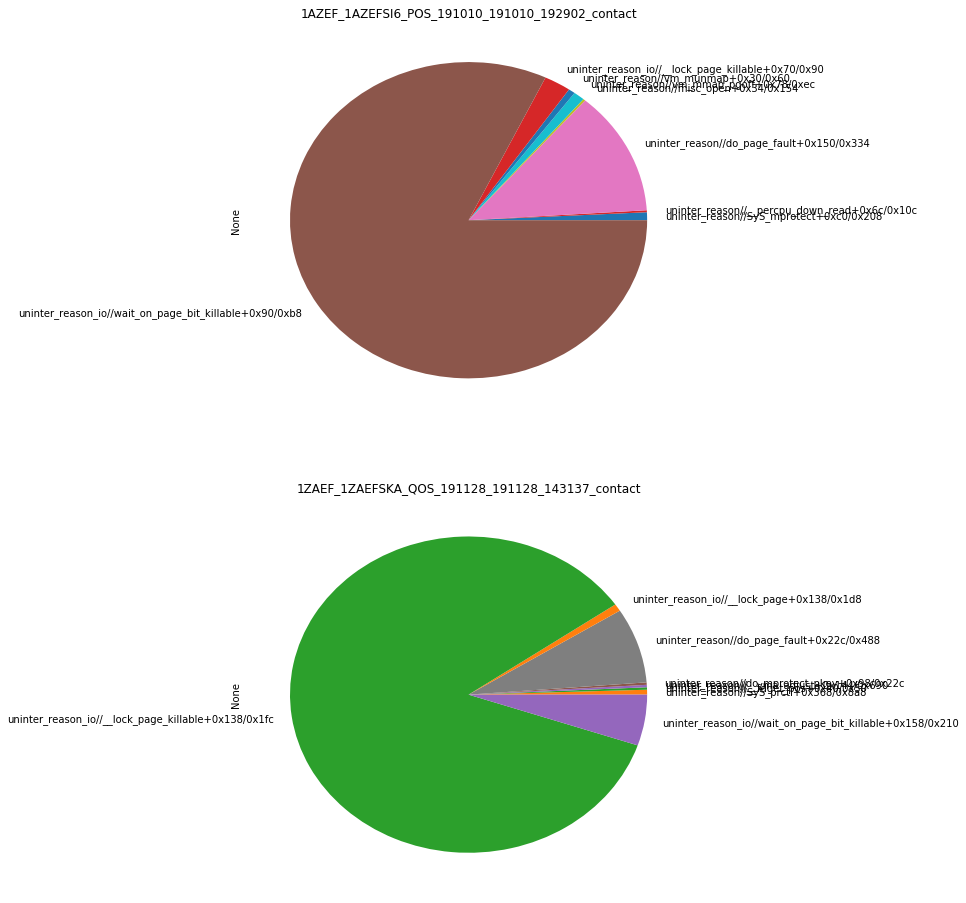

In [24]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

Choreographer #0  \
1AZEF_1AZEFSI6_POS_191010_191010_192902_contact core0                 2   
                                                core1                 0   
                                                core2                 3   
                                                core3                 0   
                                                core4                 3   
                                                core5                 2   
                                                core6                47   
                                                core7                60   
1ZAEF_1ZAEFSKA_QOS_191128_191128_143137_contact core0                68   
                                                core1                13   
                                                core2                 7   
                                                core3                 2   
                                                core4                 1   
                                                core5                 1   
                                                core6                 0   
                                                core7                 1   

                                                       Choreographer #1  \
1AZEF_1AZEFSI6_POS_191010_191010_192902_contact core0                 0   
                                                core1                 0   
                                                core2                 0   
                                                core3                 0   
                                                core4                 0   
                                                core5                 2   
                                                core6                 0   
                                                core7                15   
1ZAEF_1ZAEFSKA_QOS_191128_191128_143137_contact core0                19   
                                                core1                 2   
                                                core2                 4   
                                                core3                 0   
                                                core4                 0   
                                                core5                 0   
                                                core6                 0   
                                                core7                 0   

                                                       activityStart  \
1AZEF_1AZEFSI6_POS_191010_191010_192902_contact core0             58   
                                                core1             33   
                                                core2             40   
                                                core3             35   
                                                core4             55   
                                                core5             89   
                                                core6            174   
                                                core7            261   
1ZAEF_1ZAEFSKA_QOS_191128_191128_143137_contact core0            212   
                                                core1            125   
                                                core2            109   
                                                core3             47   
                                                core4             10   
                                                core5             22   
                                                core6             13   
                                                core7             31   

                                                       activityResume  
1AZEF_1AZEFSI6_POS_191010_191010_192902_contact core0               1  
                                                core1               0  
                                                core2         

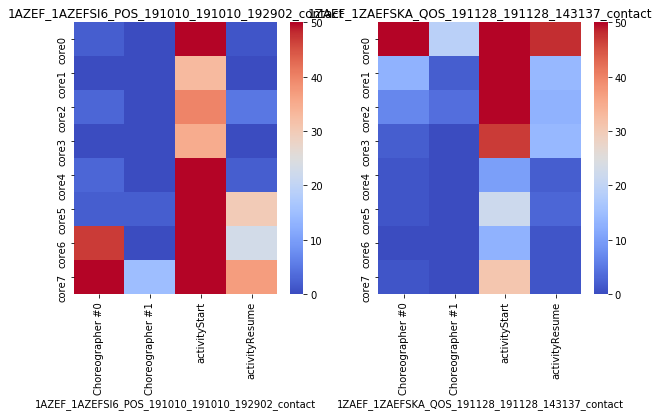

In [25]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)

In [ ]:
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

In [ ]:
plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [26]:
print(group1.title)
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,2,0,NaN,29,NaN,0,NaN
core1,NaN,0,0,NaN,21,NaN,0,NaN
core2,NaN,1,0,NaN,17,NaN,4,NaN
core3,NaN,0,0,NaN,15,NaN,0,NaN
core4,NaN,1,0,NaN,23,NaN,1,NaN
core5,NaN,1,0,NaN,31,NaN,8,NaN
core6,NaN,14,0,NaN,62,NaN,19,NaN
core7,NaN,20,5,NaN,81,NaN,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,19,NaN,1,NaN
core1,NaN,0,0,NaN,9,NaN,0,NaN
core2,NaN,1,0,NaN,14,NaN,1,NaN
core3,NaN,0,0,NaN,8,NaN,0,NaN
core4,NaN,1,0,NaN,25,NaN,0,NaN
core5,NaN,0,0,NaN,21,NaN,11,NaN
core6,NaN,7,0,NaN,47,NaN,1,NaN
core7,NaN,27,5,NaN,94,NaN,21,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,10,NaN,0,NaN
core1,NaN,0,0,NaN,3,NaN,0,NaN
core2,NaN,1,0,NaN,9,NaN,0,NaN
core3,NaN,0,0,NaN,12,NaN,0,NaN
core4,NaN,1,0,NaN,7,NaN,1,NaN
core5,NaN,1,2,NaN,37,NaN,11,NaN
core6,NaN,26,0,NaN,65,NaN,3,NaN
core7,NaN,13,5,NaN,86,NaN,16,NaN


In [27]:
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,22,4,NaN,64,NaN,18,NaN
core1,NaN,5,1,NaN,38,NaN,1,NaN
core2,NaN,3,3,NaN,41,NaN,0,NaN
core3,NaN,2,0,NaN,28,NaN,11,NaN
core4,NaN,0,0,NaN,5,NaN,0,NaN
core5,NaN,1,0,NaN,7,NaN,0,NaN
core6,NaN,0,0,NaN,6,NaN,0,NaN
core7,NaN,0,0,NaN,12,NaN,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,25,9,NaN,65,NaN,16,NaN
core1,NaN,3,0,NaN,45,NaN,8,NaN
core2,NaN,2,0,NaN,37,NaN,6,NaN
core3,NaN,0,0,NaN,8,NaN,1,NaN
core4,NaN,0,0,NaN,3,NaN,1,NaN
core5,NaN,0,0,NaN,14,NaN,0,NaN
core6,NaN,0,0,NaN,1,NaN,0,NaN
core7,NaN,0,0,NaN,8,NaN,1,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,21,6,NaN,83,NaN,14,NaN
core1,NaN,5,1,NaN,42,NaN,5,NaN
core2,NaN,2,1,NaN,31,NaN,7,NaN
core3,NaN,0,0,NaN,11,NaN,2,NaN
core4,NaN,1,0,NaN,2,NaN,1,NaN
core5,NaN,0,0,NaN,1,NaN,3,NaN
core6,NaN,0,0,NaN,6,NaN,1,NaN
core7,NaN,1,0,NaN,11,NaN,0,NaN


In [27]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [29]:
display(GetCoreStats(group1))

0  1  2  3  4  5  6  7  selected        time
activityStart    0    I  I  I  I  I  V  R  I         5  334.406358
                 1    I  I  I  I  I  V  I  I         5  334.407112
                 2    I  I  I  I  I  I  I  V         7  334.408117
                 3    I  I  I  I  I  I  R  V         7  334.411875
                 4    I  I  I  R  I  I  R  V         7  334.412167
                 5    I  I  I  I  I  I  R  V         7  334.414222
                 6    I  I  I  I  I  I  R  V         7  334.414246
                 7    I  I  I  I  I  I  R  V         7  334.414267
                 8    I  I  I  R  I  V  I  R         5  334.414362
                 9    I  I  I  R  I  I  V  R         6  334.414409
                 10   I  I  I  I  I  I  V  R         6  334.414434
                 11   I  I  I  V  R  R  I  I         3  334.417407
                 12   I  I  R  V  R  R  R  R         3  334.457716
                 13   I  I  I  R  R  V  I  R         5  334.461866
                 14   I  R  R  I  R  V  I  I         5  334.463256
                 15   I  I  I  R  I  R  I  V         7  334.464127
                 16   I  I  I  I  I  I  I  V         7  334.467510
                 17   I  I  I  R  I  R  R  V         7  334.470562
                 18   I  I  I  I  I  I  V  R         6  334.471078
                 19   I  I  I  I  I  R  R  V         7  334.471609
                 20   V  I  R  R  R  R  R  I         0  334.472664
                 21   I  I  I  R  I  I  R  V         7  334.473325
                 22   I  I  I  R  I  R  R  V         7  334.473488
                 23   R  I  I  I  R  R  R  V         7  334.474040
                 24   R  I  I  I  R  R  I  V         7  334.474482
                 25   I  I  I  R  R  R  I  V         7  334.474743
                 26   I  I  I  I  R  R  V  R         6  334.475088
                 27   I  I  R  V  R  R  R  I         3  334.475511
                 28   I  I  R  V  I  R  I  I         3  334.475811
                 29   R  I  I  I  I  I  R  V         7  334.476316
                 30   R  I  I  R  I  I  V  I         6  334.476903
                 31   I  I  I  I  I  R  V  R         6  334.477291
                 32   I  I  I  R  R  R  V  R         6  334.477425
                 33   I  I  R  I  I  V  I  R         5  334.480292
                 34   I  I  R  I  R  R  V  R         6  334.481530
                 35   I  I  I  I  I  R  V  I         6  334.482231
                 36   I  I  I  R  I  I  I  V         7  334.483476
                 37   I  I  I  R  I  R  V  I         6  334.483975
                 38   I  I  I  R  I  R  V  R         6  334.484163
                 39   I  I  I  R  I  I  V  R         6  334.484523
                 40   I  I  R  I  V  R  R  R         4  334.484922
                 41   I  I  R  I  I  R  I  V         7  334.487371
                 42   I  I  R  I  V  R  I  I         4  334.487811
                 43   I  I  R  R  I  R  V  I         6  334.488941
                 44   R  I  I  I  R  R  V  R         6  334.490576
                 45   V  R  I  I  R  R  I  R         0  334.491736
                 46   I  I  I  I  R  R  R  V         7  334.492600
                 47   R  I  I  I  I  R  V  R         6  334.493839
                 48   I  I  I  I  I  R  I  V         7  334.494925
                 49   I  I  I  I  R  R  V  R         6  334.495544
                 50   R  I  I  I  R  V  I  R         5  334.496858
                 51   I  I  I  R  V  I  I  R         4  334.497894
                 52   R  R  I  I  I  V  R  R         5  334.504197
                 53   I  R  I  I  I  I  I  V         7  334.504908
                 54   R  R  I  R  I  I  I  V         7  334.505166
                 55   R  I  R  R  I  I  I  V         7  334.506074
                 56   I  I  R  R  I  I  V  I         6  334.507550
                 57   I  R  R  R  I  V  I  I         5  334.508119
                 58   R  I  I  V  I  R  R  I         3  334.509701
  

In [30]:
display(GetCoreStats(group2))

0  1  2  3  4  5  6  7  selected        time
activityStart    0    I  I  I  I  I  I  I  V         7  314.230694
                 1    I  I  I  I  I  I  I  V         7  314.237563
                 2    I  I  I  I  I  I  I  V         7  314.240343
                 3    I  I  I  I  R  I  V  I         6  314.241519
                 4    I  I  I  I  R  I  V  I         6  314.241582
                 5    I  I  I  I  I  I  V  R         6  314.242250
                 6    I  I  I  I  V  R  R  I         4  314.271117
                 7    I  I  I  I  I  I  R  V         7  314.279163
                 8    I  I  I  I  I  I  R  V         7  314.280289
                 9    I  I  I  I  R  I  I  V         7  314.283838
                 10   I  I  I  I  I  I  I  V         7  314.284509
                 11   I  I  I  I  R  I  I  V         7  314.287422
                 12   V  I  I  I  I  R  I  I         0  314.298047
                 13   V  I  I  I  I  R  I  I         0  314.298754
                 14   V  I  I  I  R  R  I  I         0  314.301089
                 15   R  V  R  I  I  R  I  I         1  314.302069
                 16   R  R  I  V  R  R  I  R         3  314.302580
                 17   V  I  I  I  I  I  I  R         0  314.304474
                 18   I  V  I  I  R  R  I  R         1  314.304874
                 19   I  V  I  I  I  R  I  R         1  314.305195
                 20   I  V  I  I  I  I  I  R         1  314.305865
                 21   R  V  I  I  I  I  I  R         1  314.306205
                 22   R  R  V  I  R  I  I  R         2  314.306632
                 23   V  I  I  I  R  I  I  R         0  314.307000
                 24   R  V  I  I  R  I  I  R         1  314.307369
                 25   I  V  I  I  R  I  I  R         1  314.307992
                 26   V  R  I  I  R  I  I  R         0  314.308959
                 27   R  I  V  I  I  I  I  R         2  314.310048
                 28   V  I  I  I  R  I  I  R         0  314.310248
                 29   V  I  I  I  R  I  I  R         0  314.310695
                 30   V  I  I  I  I  R  I  I         0  314.317202
                 31   I  V  I  I  R  I  R  I         1  314.318764
                 32   I  V  I  I  I  I  I  R         1  314.320829
                 33   I  V  I  I  I  I  R  I         1  314.322521
                 34   I  R  I  V  I  R  R  I         3  314.323551
                 35   V  I  R  R  R  R  R  I         0  314.323972
                 36   I  I  V  I  R  I  I  I         2  314.325924
                 37   V  I  I  I  R  R  I  R         0  314.330478
                 38   R  V  I  I  I  I  R  I         1  314.333029
                 39   R  R  V  I  R  I  I  I         2  314.339046
                 40   V  I  I  I  R  R  I  I         0  314.340038
                 41   V  I  I  I  R  R  I  R         0  314.340247
                 42   V  I  I  I  R  I  R  R         0  314.341269
                 43   I  V  I  I  I  I  I  I         1  314.341762
                 44   V  R  I  I  R  R  R  I         0  314.345636
                 45   R  R  V  I  I  R  R  R         2  314.347062
                 46   I  I  V  I  I  I  I  I         2  314.347497
                 47   I  I  V  I  I  R  I  R         2  314.347730
                 48   I  I  V  I  I  I  I  I         2  314.347858
                 49   I  I  V  I  I  I  I  I         2  314.348849
                 50   I  I  V  I  R  I  R  I         2  314.349301
                 51   V  I  I  I  I  I  I  I         0  314.356339
                 52   R  V  I  I  R  R  I  I         1  314.357158
                 53   I  V  I  I  R  R  I  I         1  314.358005
                 54   I  V  R  I  R  I  I  I         1  314.358136
                 55   I  R  V  I  R  R  R  R         2  314.358554
                 56   V  I  I  I  R  R  R  I         0  314.359402
                 57   I  V  I  I  I  I  I  I         1  314.362342
                 58   V  I  I  I  I  R  I  I         0  314.366550
  

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [30]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

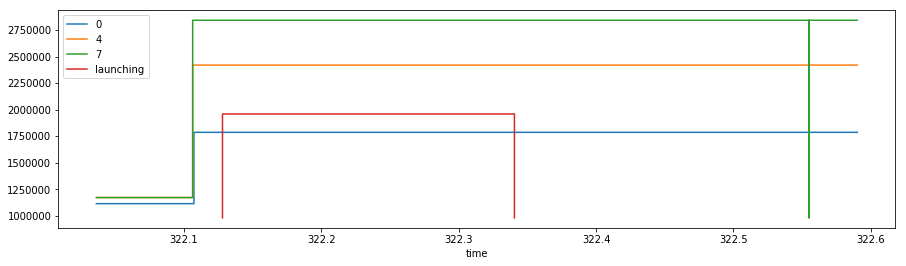

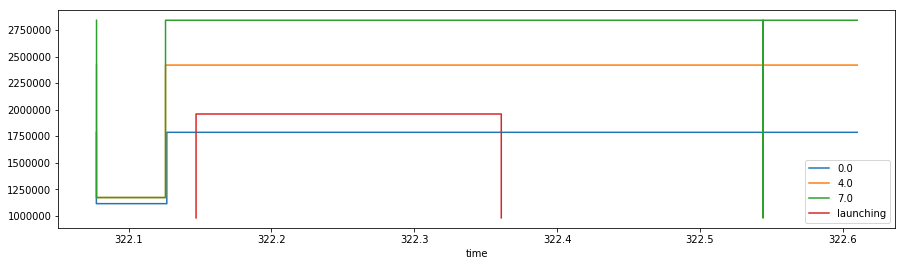

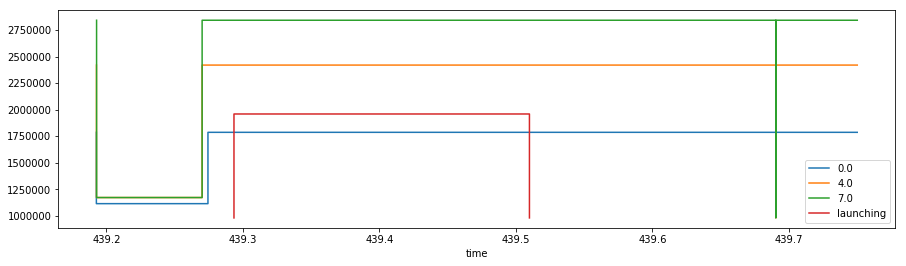

In [31]:
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

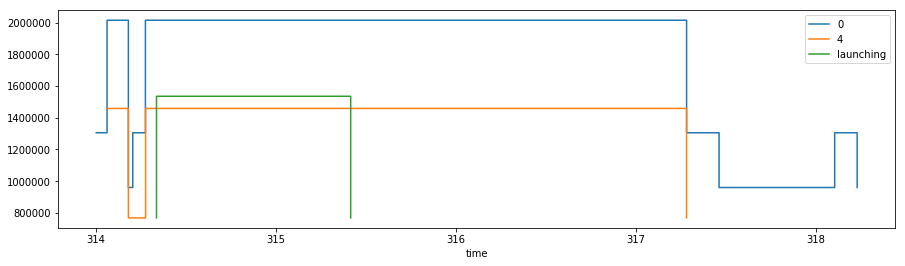

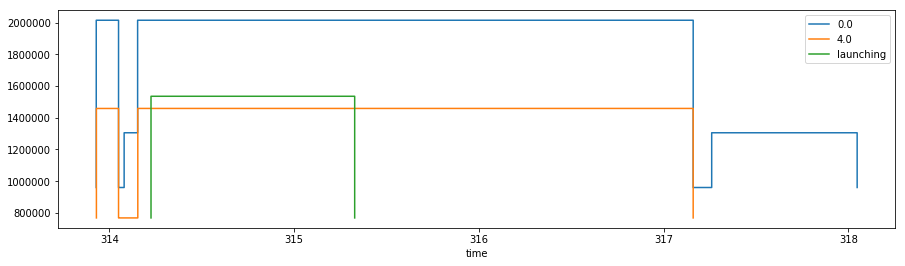

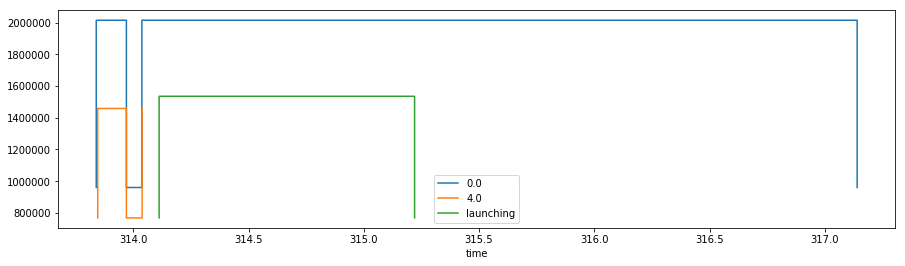

In [33]:
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [33]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

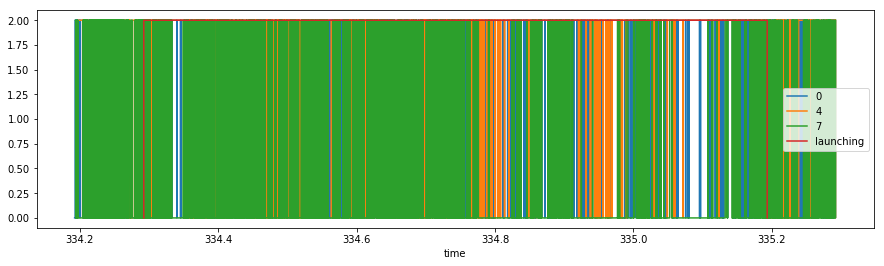

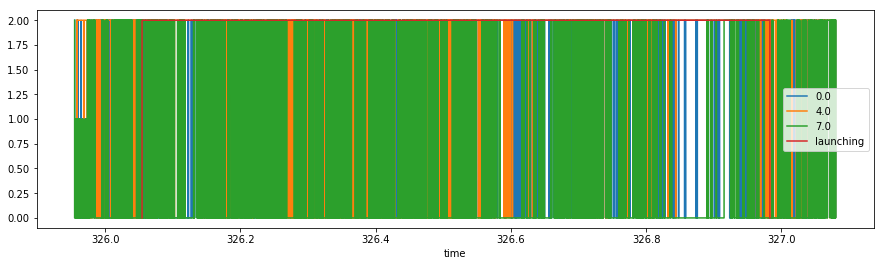

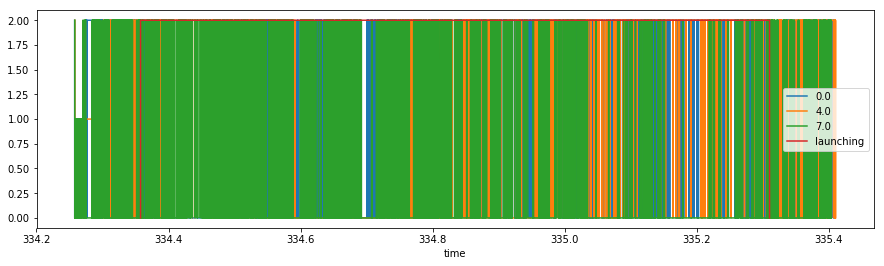

In [35]:
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

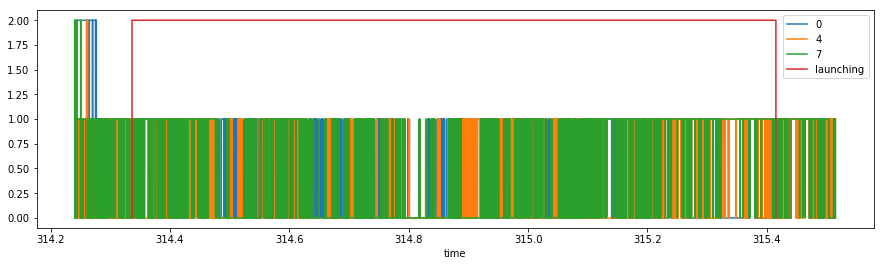

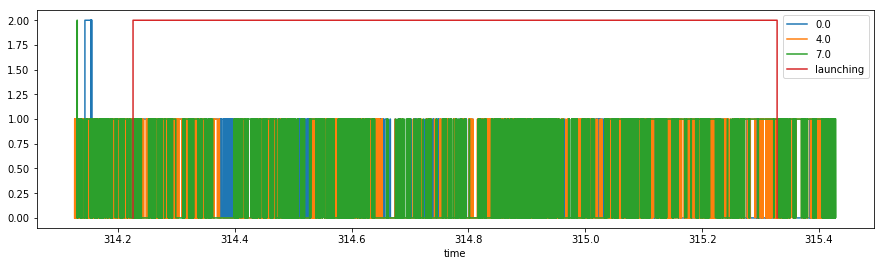

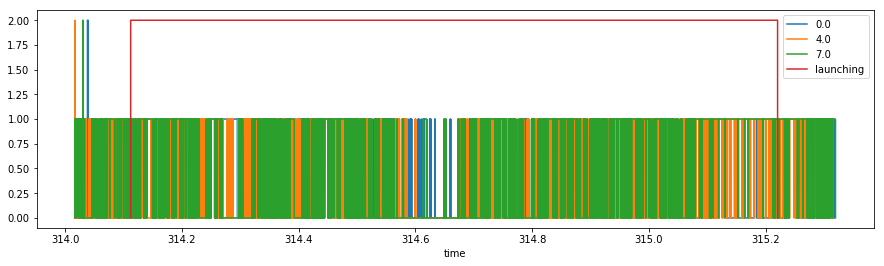

In [36]:
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [37]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
1AZEF_1AZEFSI6_POS_191010_191010_192902_contact,lock_contention,0,11.763,0,0,39.469,0,0.000,0
1ZAEF_1ZAEFSKA_QOS_191128_191128_143137_contact,lock_contention,0,15.380,0,0,42.200,0,3.192,0
DIFF,lock_contention,0,-3.617,0,0,-2.731,0,-3.192,0


In [ ]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

In [37]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [39]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'1AZEF_1AZEFSI6_POS_191010_191010_192902_contact'

,blocking,context,duration,effection,owner,pid,time,type
22,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:4058_9 (4...,29.575,O,Binder:4058_9 (4890),5410,334.327981,B
34,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (41...,12.353,O,android.anim (4136),4091,334.397028,B
46,void com.android.server.wm.WindowSurfacePlace...,monitor contention with owner Binder:4058_E (5...,12.025,O,Binder:4058_E (5393),4136,334.634420,B
41,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (41...,10.919,O,android.anim (4136),7168,334.488758,B
42,java.util.List com.android.server.am.Activity...,monitor contention with owner Binder:4058_E (5...,8.599,O,Binder:4058_E (5393),4482,334.496753,B
49,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (41...,7.824,O,android.anim (4136),4091,334.653136,B
85,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:4058_14 (...,7.638,O,Binder:4058_14 (5422),4091,335.005554,B
19,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:4058_9 (4...,6.939,O,Binder:4058_9 (4890),4091,334.316259,B
28,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:4058_E (5...,4.616,O,Binder:4058_E (5393),4091,334.361297,B
52,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:4058_14 (...,3.957,O,Binder:4058_14 (5422),4091,334.684352,B


In [40]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'1ZAEF_1ZAEFSKA_QOS_191128_191128_143137_contact'

,blocking,context,duration,effection,owner,pid,time,type
8,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1378_A (2...,91.189,O,Binder:1378_A (2323) at android.app.ContentPro...,1463,314.387967,B
7,void com.android.server.wm.WindowProcessContr...,monitor contention with owner Binder:1378_15 (...,88.436,O,Binder:1378_15 (4136) at void com.android.serv...,2323,314.385437,B
9,java.lang.String com.android.server.am.Activi...,monitor contention with owner Binder:1378_A (2...,41.503,O,Binder:1378_A (2323) at android.app.ContentPro...,1471,314.437828,B
10,float com.android.server.wm.WindowManagerServ...,monitor contention with owner Binder:1378_D (3...,26.232,O,Binder:1378_D (3338) at void com.android.serve...,4136,314.448820,B
40,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1378_D (3...,19.288,O,Binder:1378_D (3338) at void com.android.serve...,1451,314.540449,B
102,void com.android.server.wm.WindowSurfacePlace...,monitor contention with owner Binder:1378_15 (...,17.786,O,Binder:1378_15 (4136) at void com.android.serv...,1471,314.913895,B
42,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1378_D (3...,17.473,O,Binder:1378_D (3338) at void com.android.serve...,1463,314.542365,B
57,boolean com.android.server.wm.WindowManagerSe...,monitor contention with owner android.anim (14...,11.595,O,android.anim (1471) at void com.android.server...,2007,314.618801,B
19,void com.android.server.am.ProcessList.lambda...,monitor contention with owner android.display ...,11.175,O,android.display (1463) at void com.android.ser...,1455,314.506823,B
26,void com.android.server.wm.ActivityStackSuper...,monitor contention with owner android.anim (14...,9.678,O,android.anim (1471) at int com.android.server....,1463,314.523673,B


In [41]:
display(group1.title)
display(df1['duration'].sum())

u'1AZEF_1AZEFSI6_POS_191010_191010_192902_contact'

130.62399999995478

In [42]:
display(group2.title)
display(df2['duration'].sum())

u'1ZAEF_1ZAEFSKA_QOS_191128_191128_143137_contact'

466.2089999995942

Sum of the lock contention's duration. The durations could be duplicated.

Liminated the lock contentions by owners.

In [43]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'1AZEF_1AZEFSI6_POS_191010_191010_192902_contact'

,owner
Binder:4058_14 (5422),12
Binder:4058_E (5393),8
android.anim (4136),5
Binder:4058_19 (7168),5
Binder:4058_9 (4890),4
main (4058),4
ActivityManager (4080),3
android.bg (4079),3
Binder:4058_16 (5424),2
Binder:4058_10 (5410),2


In [44]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'1ZAEF_1ZAEFSKA_QOS_191128_191128_143137_contact'

,owner
android.anim (1471) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),4
"android.display (1463) at void com.android.server.wm.ActivityMetricsLogger.checkVisibility(com.android.server.wm.TaskRecord, com.android.server.wm.ActivityRecord)(ActivityMetricsLogger.java:633)",3
"android.display (1463) at void com.android.server.am.ActivityManagerService$LocalService.updateActivityUsageStatsWithIntent(android.content.ComponentName, int, int, android.os.IBinder, android.content.ComponentName, android.content.Intent)(ActivityManagerService.java:20528)",3
android.anim (1471) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:126),3
"ObserverHandler (1905) at android.content.pm.PackageInfo com.android.server.pm.PackageManagerService.getPackageInfoInternal(java.lang.String, long, int, int, int)(PackageManagerService.java:5241)",3
"Binder:1378_15 (4136) at void com.android.server.wm.WindowManagerService.setShelfHeight(boolean, int)(WindowManagerService.java:6452)",3
"android.anim (1471) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2249)",3
"Binder:1378_5 (2007) at void com.android.server.wm.WindowManagerService.statusBarVisibilityChanged(int, int)(WindowManagerService.java:6466)",2
"Binder:1378_D (3338) at void com.android.server.am.ActivityManagerService.attachApplication(android.app.IApplicationThread, long)(ActivityManagerService.java:6166)",2
"Binder:1378_5 (2007) at int com.android.server.pm.PackageManagerService.checkUidPermission(java.lang.String, int)(PackageManagerService.java:6682)",2


Text(0,0.5,'weight')

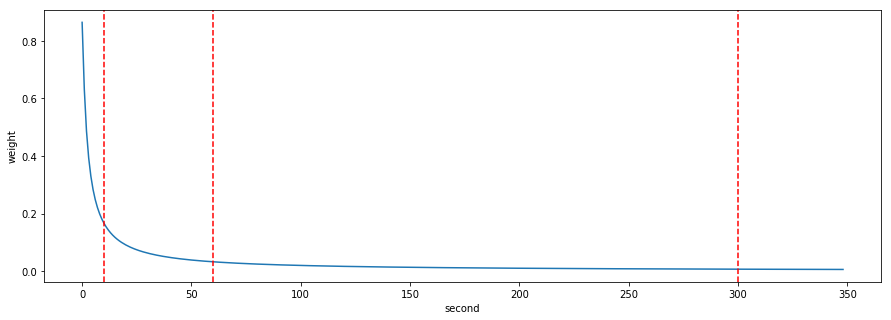

In [44]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')